Coastal Erosion Simulation and Optimization
This script demonstrates how to optimize the placement of the barriers.


Running simulation without barriers...


  0%|          | 0/99 [00:00<?, ?it/s]


Running simulation with non-optimized barriers...


  0%|          | 0/99 [00:00<?, ?it/s]


Optimizing barrier placement...


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

 c:\Users\sonia\anaconda3\envs\new_env\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

  0%|          | 0/99 [00:00<?, ?it/s]

Optimized barrier coordinates: [(2.0071461330319056, 2.728765770891206)]

Running simulation with optimized barriers...


  0%|          | 0/99 [00:00<?, ?it/s]


Erosion Summary:
Total erosion (no barriers): 4732.00
Total erosion (non-optimized barriers): 4825.00
Total erosion (optimized barriers): 4883.00


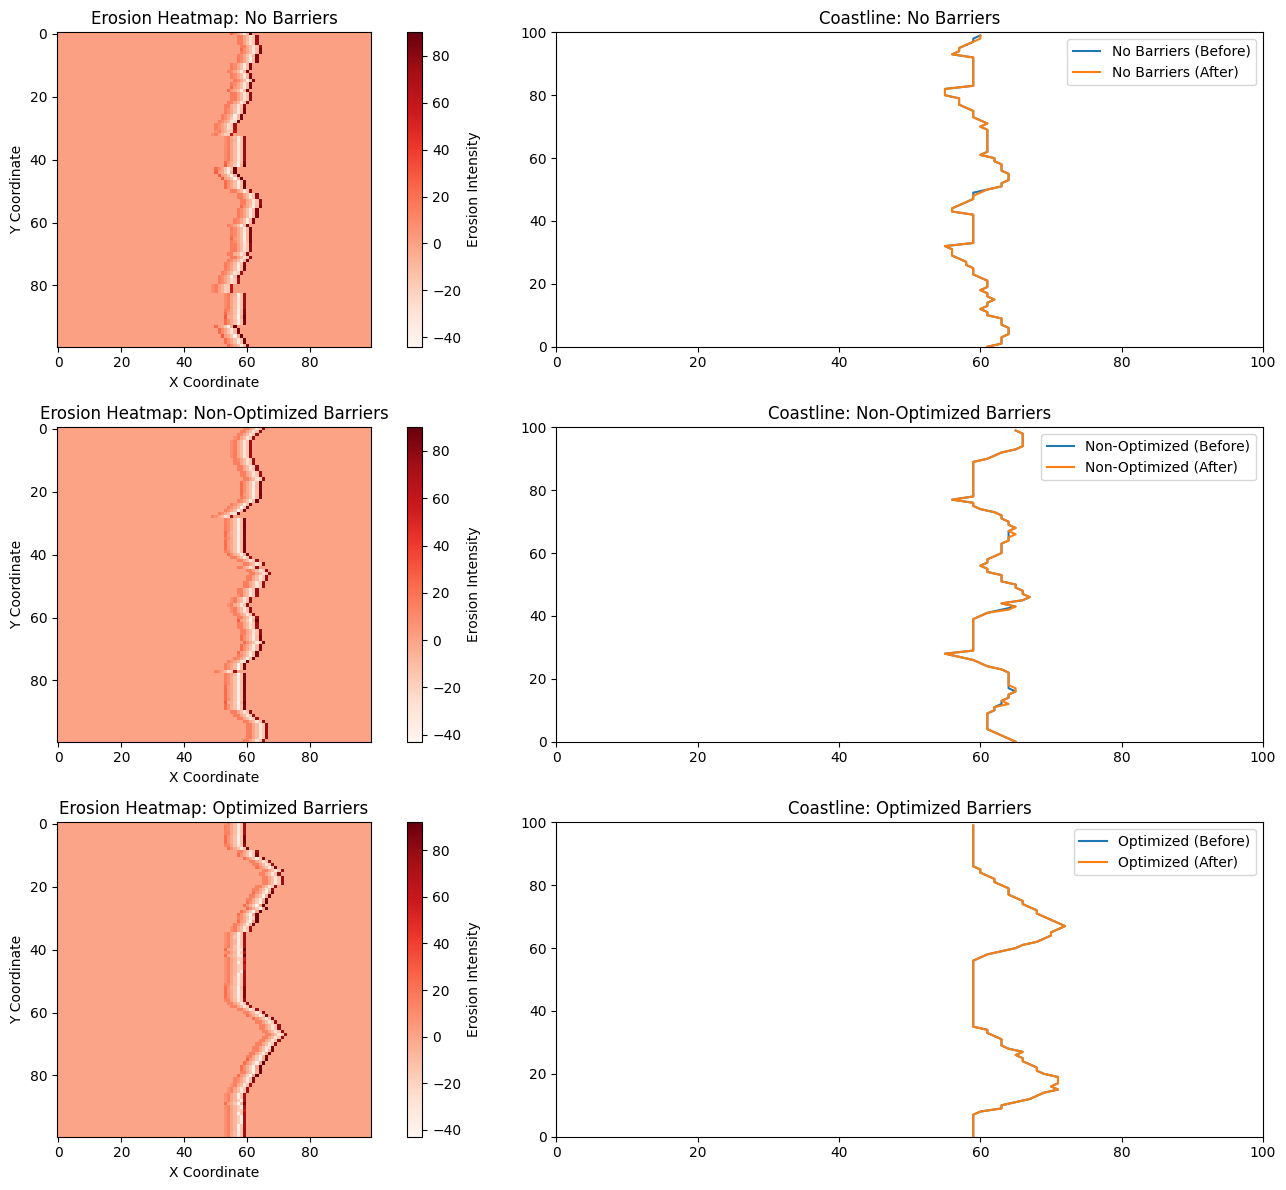

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from simulation import simulation
from optimization import OptimizationManager
from config import (
    WAVE_FREQ, WAVE_SPEED, WAVE_DECAY, WAVE_CUTOFF, WAVE_RETREAT_COEFF, WAVE_HEIGHT,
    SAND_PULL, GROUND_PULL, WATER_DECAY, WAVE_VOL, WAVE_AMPLITUDE, WAVE_SPREAD,
    DIM_MAP, OBSTACLE_COORDS
)

# Define simulation parameters
SIM_PARAMS = {
    "wave_freq": WAVE_FREQ,
    "wave_speed": WAVE_SPEED,
    "wave_decay": WAVE_DECAY,
    "wave_cutoff": WAVE_CUTOFF,
    "wave_retreat_coeff": WAVE_RETREAT_COEFF,
    "wave_height": WAVE_HEIGHT,
    "sand_pull": SAND_PULL,
    "ground_pull": GROUND_PULL,
    "water_decay": WATER_DECAY,
    "wave_vol": WAVE_VOL,
    "wave_amplitude": WAVE_AMPLITUDE,
    "wave_spread": WAVE_SPREAD,
    "dim_map": DIM_MAP
}

# Helper function for erosion heatmap
def plot_erosion_heatmap(before_map, after_map, title, cmap='Reds'):
    sand_before = before_map[:, :, 1]  # Sand layer before erosion
    sand_after = after_map[:, :, 1]    # Sand layer after erosion
    erosion_diff = sand_before - sand_after  # Difference in sand levels

    plt.imshow(erosion_diff, cmap=cmap)
    plt.colorbar(label="Erosion Intensity")
    plt.title(title)
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")

# Helper function for numerical erosion values
def calculate_total_erosion(before_map, after_map):
    sand_before = before_map[:, :, 1]
    sand_after = after_map[:, :, 1]
    total_erosion = np.sum(sand_before - sand_after)
    return total_erosion

# 1. Run simulation without barriers
print("\nRunning simulation without barriers...")
sim_no_barrier = simulation(**SIM_PARAMS, obstacle_coords=[])
before_map_no_barrier, after_map_no_barrier, _, _ = sim_no_barrier.run_sim(num_timesteps=100)

# 2. Run simulation with non-optimized barriers
print("\nRunning simulation with non-optimized barriers...")
sim_non_optimized = simulation(**SIM_PARAMS, obstacle_coords=OBSTACLE_COORDS)
before_map_non_optimized, after_map_non_optimized, _, _ = sim_non_optimized.run_sim(num_timesteps=100)

# 3. Optimize barrier placement
print("\nOptimizing barrier placement...")
def run_optimization(num_timesteps=100, n_samples=10, n_iterations=20):
    opt_manager = OptimizationManager()
    param_samples = opt_manager.sample_parameters(n_samples)
    
    # Run initial simulations
    outcomes = []
    for params in param_samples:
        outcomes.append(opt_manager.wrapped_run_sim(params))
    
    # Convert results to numpy arrays
    X = np.array(param_samples)
    Y = np.array(outcomes).reshape(-1, 1)
    
    # Run Bayesian optimization
    loop_state = opt_manager.run_optimization(X, Y, n_iterations=n_iterations)
    
    # Extract the best parameters
    best_parameters = loop_state.X[-1]
    return [(best_parameters[i], best_parameters[len(OBSTACLE_COORDS) + i]) for i in range(len(OBSTACLE_COORDS))]

optimized_coords = run_optimization()
print(f"Optimized barrier coordinates: {optimized_coords}")

# 4. Run simulation with optimized barriers
print("\nRunning simulation with optimized barriers...")
sim_optimized = simulation(**SIM_PARAMS, obstacle_coords=optimized_coords)
before_map_optimized, after_map_optimized, _, _ = sim_optimized.run_sim(num_timesteps=100)

# 5. Visualization
plt.figure(figsize=(15, 12))

# Heatmap for no barriers
plt.subplot(3, 2, 1)
plot_erosion_heatmap(before_map_no_barrier, after_map_no_barrier, "Erosion Heatmap: No Barriers")

# Heatmap for non-optimized barriers
plt.subplot(3, 2, 3)
plot_erosion_heatmap(before_map_non_optimized, after_map_non_optimized, "Erosion Heatmap: Non-Optimized Barriers")

# Heatmap for optimized barriers
plt.subplot(3, 2, 5)
plot_erosion_heatmap(before_map_optimized, after_map_optimized, "Erosion Heatmap: Optimized Barriers")

# Numerical summary
erosion_no_barrier = calculate_total_erosion(before_map_no_barrier, after_map_no_barrier)
erosion_non_optimized = calculate_total_erosion(before_map_non_optimized, after_map_non_optimized)
erosion_optimized = calculate_total_erosion(before_map_optimized, after_map_optimized)

print("\nErosion Summary:")
print(f"Total erosion (no barriers): {erosion_no_barrier:.2f}")
print(f"Total erosion (non-optimized barriers): {erosion_non_optimized:.2f}")
print(f"Total erosion (optimized barriers): {erosion_optimized:.2f}")

# Coastline comparison
def plot_coast(sim, before_map, after_map, label_before, label_after):
    coords_before = sim.get_coast_coords(before_map, limit=0)
    coords_after = sim.get_coast_coords(after_map, limit=0)
    sim.plot_coast(coords_before, label=label_before)
    sim.plot_coast(coords_after, label=label_after)

plt.subplot(3, 2, 2)
plot_coast(sim_no_barrier, before_map_no_barrier, after_map_no_barrier, "No Barriers (Before)", "No Barriers (After)")
plt.title("Coastline: No Barriers")
plt.legend()

plt.subplot(3, 2, 4)
plot_coast(sim_non_optimized, before_map_non_optimized, after_map_non_optimized, "Non-Optimized (Before)", "Non-Optimized (After)")
plt.title("Coastline: Non-Optimized Barriers")
plt.legend()

plt.subplot(3, 2, 6)
plot_coast(sim_optimized, before_map_optimized, after_map_optimized, "Optimized (Before)", "Optimized (After)")
plt.title("Coastline: Optimized Barriers")
plt.legend()

plt.tight_layout()
plt.show()
